<a href="https://colab.research.google.com/github/MINED30/MODELING/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
batch_size = 32

num_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_ds = torchvision.datasets.CIFAR10(root="data/", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.CIFAR10(root="data/", train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [3]:
def imshow(img,label,pltshow=False):    # unnormalize
    npimg = img.numpy()
    plt.title(label)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if pltshow:
      plt.show()

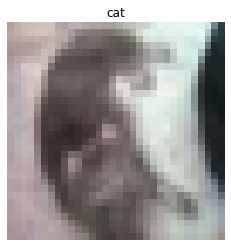

In [4]:
for images, labels in train_loader:
    imshow(images[0],classes[labels[0].item()],True)
    break

# Build Model

## Before Encoder

### Linear Projection of Flattened Pathes

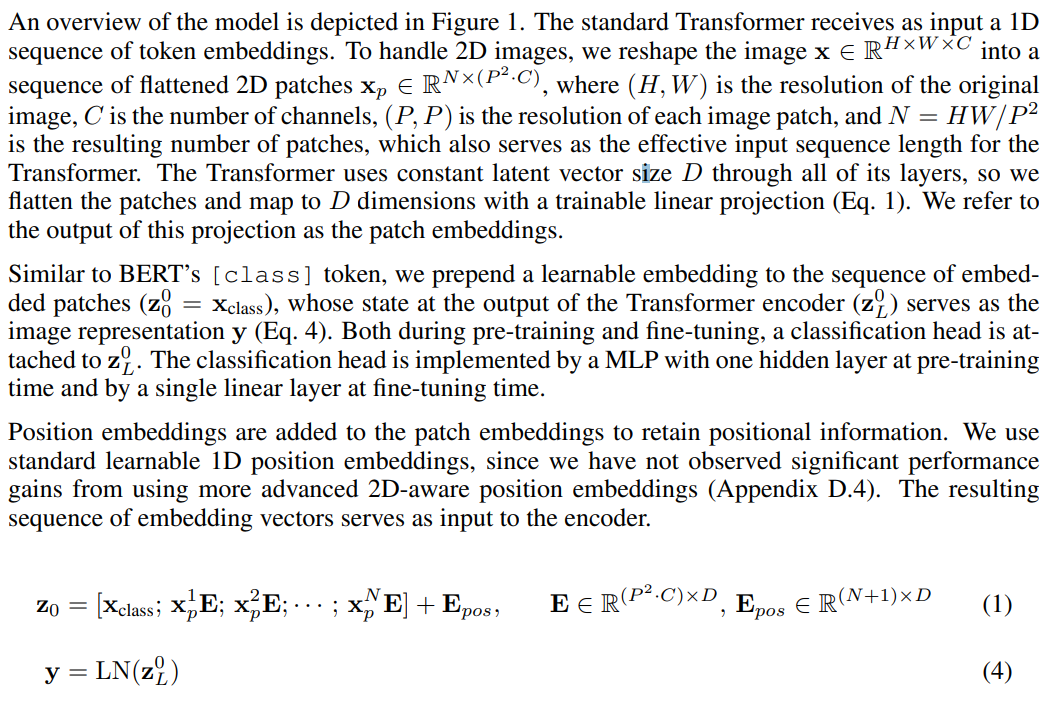

$(H, W, C) -> (N,P^2*C)$

$(32,32,3) -> (64,4^2*3)==(16,48)$


In [5]:
class PatchEmbedding(nn.Module):
  def __init__(self, 
               batch_size=32,
               height:int=32, 
               width:int=32, 
               n_channel:int=3, 
               patch_size:int=4,
               emb_size:int=768,
               device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
               **kwargs):
    super().__init__()
    self.height = height
    self.width = width
    self.n_channel = n_channel

    self.patch_size = patch_size
    self.n_patches = int((height*width)/(patch_size**2)) # N = HW/P^2

    self.emb_size = emb_size
    self.linear_projection = nn.Linear((patch_size**2)*n_channel, emb_size)

    self.cls_token = nn.Parameter(data=torch.randn(1,1, emb_size), requires_grad=True)
    self.positions = nn.Parameter(data=torch.randn(self.n_patches + 1, emb_size), requires_grad=True)

  def forward(self,inputs):
    patches = self.extract_patches(inputs)  # (B, N, C, P, P) == (32, 64, 3, 4, 4)
    flattened_patches = patches.flatten(2)  # (B, N, C*P^2) == (32, 64, 48)
    projection = self.linear_projection(flattened_patches)  # (B, N, emb_size) == (32, 64, 768)

    cls_tokens = self.cls_token # CLS : (B, 1, emb_size) == (32, 1, 768)

    output = torch.cat([cls_tokens.repeat(inputs.shape[0],1,1),projection],dim=1)
    output += self.positions  # OUT : (B, N+1, emb_size) == (32, 65, 768)
    return output

  def extract_patches(self, img):
    # input image : B, C, H, W
    patch_fold_H = img.unfold(2,self.patch_size,self.patch_size)  # patch_fold_H : (B, C, H/Patchsize, W, Patchsize_H)
    patches = patch_fold_H.unfold(3, self.patch_size,self.patch_size) # patch_fold_H : (B, C, H/Patchsize(N_H), W/Patchsize(N_W), Patchsize_H, Patchsize_W)
    patches = patches.permute(0,2,3,1,4,5) # patches : (B, N_H, N_W, C, Patchsize_H, Patchsize_W)
    patches = patches.reshape(-1,self.n_patches,self.n_channel, self.patch_size,self.patch_size) # patches : (B, N, Patchsize_H, Patchsize_W)
    return patches


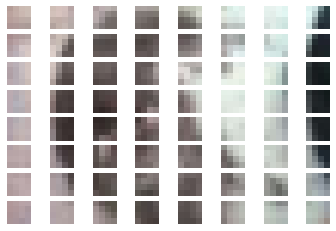

In [6]:
pe = PatchEmbedding(device='cpu')
patches = pe.extract_patches(images[0:1])[0]
for i in range(64):
  plt.subplot(8,8,i+1)
  imshow(patches[i].detach().to('cpu'),None)
plt.show()

## Encoder

### LN(Layer Normalization)

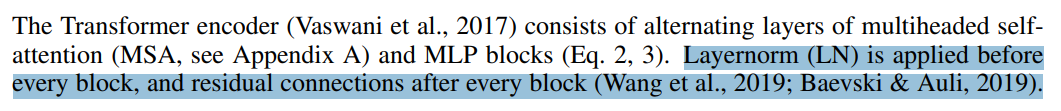

Layer normalization (Ba et al., 2016).

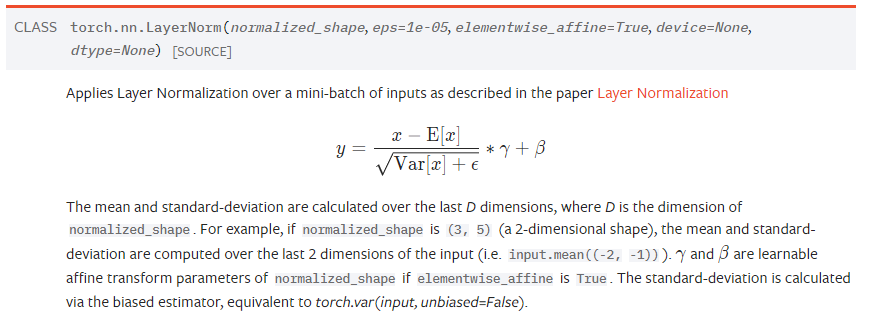

### MSA(Multihead Self Attention)

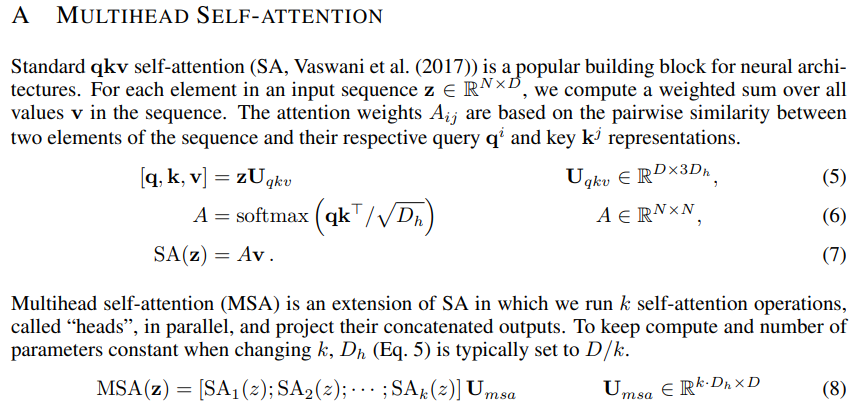

In [7]:
class MSA(nn.Module):
  def __init__(self, emb_size=768, num_heads=12, return_attn_output_weights=False, **kwargs):
      super().__init__()
      self.emb_size = emb_size
      self.num_heads = num_heads
      self.multi_head_dim = self.emb_size // self.num_heads

      self.ln = nn.LayerNorm((emb_size))

      self.query = nn.Linear(emb_size,emb_size)
      self.key = nn.Linear(emb_size,emb_size)
      self.value = nn.Linear(emb_size,emb_size)

      self.softmax = nn.Softmax(dim=-1)
      self.return_attn_output_weights = return_attn_output_weights

  def forward(self,inputs):
      # Norm
      inputs = self.ln(inputs)

      # Q K V
      q = self.query(inputs)  # (B, N+1, emb_size) == (32, 65, 768)
      k = self.key(inputs)    # (B, N+1, emb_size) == (32, 65, 768)
      v = self.value(inputs)  # (B, N+1, emb_size) == (32, 65, 768)

      # Multihead split
      q = self.multihead_split(q) # (B, H, N, emb_size/H ) == (32, 12, 65, 64)
      k = self.multihead_split(k) # (B, H, N, emb_size/H ) == (32, 12, 65, 64)
      v = self.multihead_split(v) # (B, H, N, emb_size/H ) == (32, 12, 65, 64)

      a = self.scaled_dot_product(q,k,v) # A : Attention Weight (B, H, N, N)==(32,12,65,65)
      output = torch.matmul(a,v) # Av : (B, H, N, emb_size/H) == (32, 12, 65 64)
      output =  self.multihead_merge(output) # (B, N, emb_size) == (32, 65, 768)

      if self.return_attn_output_weights:
        # output : (B, N+1, emb_size)==(32, 65, 768)
        # a : (B, N+1, N+1)==(32, 65, 65)
        return output, a
      else:
        return output

  def multihead_split(self, x):
      B, N, emb_size = x.shape  # (B, N, emb_size)

      x = x.reshape(B, N, self.num_heads, self.multi_head_dim) # (B, N, H, emb_size/H )
      x = x.permute(0, 2, 1, 3) # (B, H, N, emb_size/H )
      return x

  def multihead_merge(self,x):
      B, H, N, multi_head_dim = x.shape
      x = x.permute(0, 2, 1, 3) # (B, N, H, emb_size/H )
      x = x.reshape(B, N, self.emb_size)  # (B, N, emb_size)
      return x

  def scaled_dot_product(self, q, k, v):
      qk_t = torch.matmul(q, k.transpose(2,3)) # batched matrix x batched matrix
      root_d_h = self.multi_head_dim**0.5
      attention_weight = self.softmax(qk_t/root_d_h)
      return attention_weight

### MultiLayerPerceptron

In [8]:
class MLP(nn.Module):
  def __init__(self,emb_size=768, mlp_size=3072, **kwargs):
    super().__init__()
    self.ln = nn.LayerNorm((emb_size))
    self.mlp_in = nn.Linear(emb_size, mlp_size)
    self.gelu = nn.GELU()
    self.mlp_out = nn.Linear(mlp_size, emb_size)
    
  def forward(self,inputs):
    inputs = self.ln(inputs)
    x = self.mlp_in(inputs)
    x = self.gelu(x)
    output = self.mlp_out(x)
    return output

### Transformer Encoder

In [9]:
class VisionTransformerEncdoer(nn.Module):
    def __init__(self, config,return_attn_output_weights=False):
        super().__init__()
        self.return_attn_output_weights = return_attn_output_weights
        self.msa = MSA(return_attn_output_weights=return_attn_output_weights,**config)
        self.mlp = MLP(**config)

    def forward(self,inputs):
        # MSA BLOCK
        msa_residual = inputs
        if self.return_attn_output_weights:
          msa_output, attn_output_weights = self.msa(inputs)
        else :
          msa_output = self.msa(inputs)
        msa_output += msa_residual

        # MLP BLOCK
        mlp_output = self.mlp(msa_output) + msa_output
        if self.return_attn_output_weights:
          return mlp_output, attn_output_weights
        else :
          return mlp_output

## After Encoder

### MLP Head

In [10]:
class MLPHead(nn.Module):
  def __init__(self,emb_size=768,num_classes=10, batch_size=32,**kwargs):
    super().__init__()
    self.classifier = nn.Linear(emb_size, num_classes)
    self.ln = nn.LayerNorm((emb_size))

  def forward(self, inputs):
    # print(inputs.shape)
    x = inputs[:,0,:]
    x = self.ln(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

## ViT

In [11]:
config={
  "batch_size" : 32,
  "num_classes" : 10,
  "height" : 32,
  "width" : 32,
  "n_channel" : 3,
  "patch_size" : 4,
  "emb_size" : 768,
  "num_heads" : 12,
  "mlp_size" : 3072,
  "layers" : 12,
  "device" : torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
}

In [12]:
class VisionTransformer(nn.Module):
  def __init__(self,config,**kwargs):
    super().__init__()
    self.patch_embedding = PatchEmbedding(**config)
    self.vit_encoder = nn.Sequential(*[VisionTransformerEncdoer(config,return_attn_output_weights=False)for i in range(config['layers']-1) ])
    self.last_encoder = VisionTransformerEncdoer(config,return_attn_output_weights=True)
    self.classifier = MLPHead(**config)

  def forward(self, img):
    x = self.patch_embedding(img)
    x = self.vit_encoder(x)
    x,att = self.last_encoder(x)
    x = self.classifier(x)
    return x, att

# vit = VisionTransformer(config)
# vit.to(device)

# Train

## wandb

In [13]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 97 kB 8.3 MB/s 
     |████████████████████████████████| 180 kB 78.5 MB/s 
     |████████████████████████████████| 139 kB 72.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=24914b0722be679a30c90bbdf8d3d7a8215dc15f5bd3a1dcca6b5b9ee4263c85
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=e54b2231ba89c101e111866619fc2fd975f93170114ed3d79834df390dd5d643
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [14]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Training

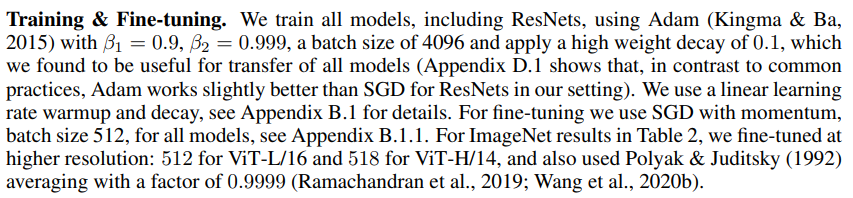

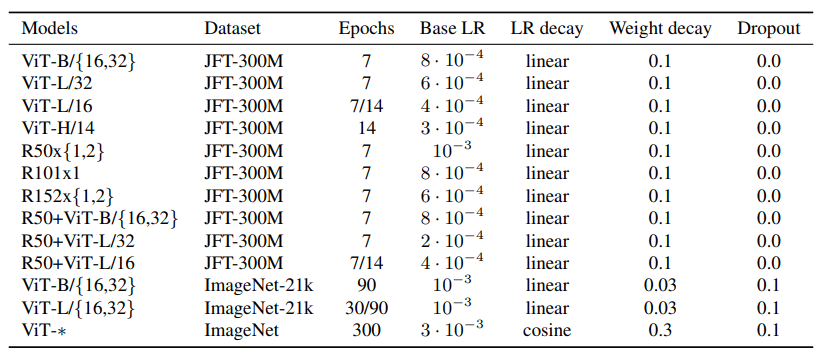

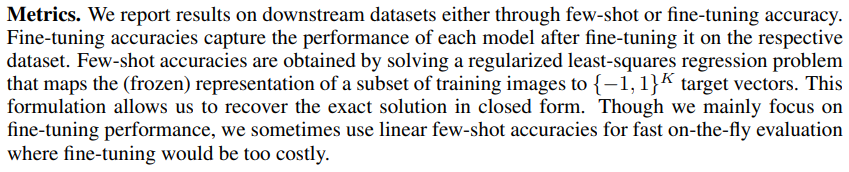

In [15]:
def figure_to_array(fig):
    fig.canvas.draw()
    return np.array(fig.canvas.renderer._renderer)

def pics_with_att(model,images,labels):
    att_img = model(images)[1].sum(axis=1)
    f = plt.figure(figsize=(5,6))
    for i in range(16):
      plt.subplot(4,4,i+1)
      plt.title(classes[labels[i]])
      plt.imshow(images[i].permute(1,2,0).to('cpu').detach().numpy())
      plt.imshow(att_img[i][0][1:].reshape(8,8).to('cpu').detach().numpy().repeat(4).reshape(8,32).repeat(4,axis=0),
                 cmap='gray',alpha=0.5)
      plt.axis("off")
    plt.close()
    return figure_to_array(f)


In [ ]:
from tqdm.auto import tqdm

model = VisionTransformer(config)
# optimizer = torch.optim.Adam(model.parameters(), lr=8e-4, betas=(0.9,0.999), weight_decay=0.1)
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 100
num_training_steps = num_epochs * len(train_loader) + num_epochs * len(test_loader)
loss_function = torch.nn.CrossEntropyLoss(reduction='none')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print("device :",device)

device : cuda


In [ ]:
with wandb.init(project="ViT-CIFAR100-v2", config=config):
    wandb.watch(model, log="all", log_freq=100)
    progress_bar = tqdm(range(num_training_steps))
    best_test_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for bindx, batch in enumerate(train_loader):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            out, att = model(images)

            loss = loss_function(out, labels.long()).sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                progress_bar.update(1)
                train_loss += loss
                batch_accuracy = (torch.argmax(out,1)==labels).sum()/len(out)
                wandb.log({"epoch": epoch, "batch":bindx, 
                           "loss": loss, "train_loss":train_loss,
                           "batch_accuracy" : batch_accuracy,
                           "attention_monitoring":(att[0]==att[1]).sum()})
                

        with torch.no_grad():
            model.eval()
            test_loss = 0
            test_correct = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                out,att = model(images)
                loss = loss_function(out, labels.long()).sum()
                test_loss += loss
                test_correct += (torch.argmax(out,1)==labels).sum()
                progress_bar.update(1)
            test_accuracy = test_correct/len(test_ds)
            att_pic = pics_with_att(model, images, labels)
            wandb_img = wandb.Image(att_pic)
            wandb.log({"epoch": epoch, "test_loss":test_loss, 
                        "test_accuracy": test_accuracy, "test_img":wandb_img})
        if best_test_accuracy < test_accuracy:
            torch.save(model.state_dict(), f"/content/drive/MyDrive/논문구현/ViT/ViT_{epoch}epoch.pt")



  0%|          | 0/187600 [00:00<?, ?it/s]

# Evaluation

## Load Model

In [66]:
model = VisionTransformer(config)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/논문구현/ViT/ViT_33epoch.pt"))

<All keys matched successfully>

##Evaluation on Trainset

In [ ]:
from tqdm.auto import tqdm
model.eval()
correct = 0
progress_bar = tqdm(range(len(train_loader)))
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    out,_ = model(images)
    correct += (torch.argmax(out,1)==labels).sum()
    progress_bar.update(1)
acc = correct/len(train_ds)
print(acc)

  0%|          | 0/1563 [00:00<?, ?it/s]

tensor(0.6732, device='cuda:0')


got 67.32% accury on train dataset.


## Evaluation on Testset

In [ ]:
from tqdm.auto import tqdm
model.eval()
correct = 0
progress_bar = tqdm(range(len(test_loader)))
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    out,_ = model(images)
    correct += (torch.argmax(out,1)==labels).sum()
    progress_bar.update(1)
acc = correct/len(test_ds)
print(acc)

  0%|          | 0/313 [00:00<?, ?it/s]

tensor(0.5027, device='cuda:0')


got 50.27% accury on train dataset.


## How this model pay attention to images


In [67]:
def plotting_attention(model, images, labels, classes):
  output, att_img = model(images)
  att_img = att_img.sum(axis=1)
  f = plt.figure(figsize=(6,10))
  for i in range(30):
    att = att_img[i][0][1:]
    att = (att - att.min())*10 / (att.max() - att.min())
    att = att.reshape(8,8).to('cpu').detach().numpy().repeat(4).reshape(8,32).repeat(4,axis=0)
    att = np.minimum(att,1)
    ones = np.full_like(att,0)
    att = np.concatenate([ones,ones,ones,att]).reshape(4,32,32).transpose(1,2,0)
    plot_img = images[i].permute(1,2,0).to('cpu').detach().numpy()
    plt.subplot(6,5,i+1)
    plt.title(f"T : {classes[labels[i]]}\nP : {classes[torch.argmax(output,dim=1)[i]]}")
    plt.imshow(plot_img)
    plt.imshow(att)
    plt.axis("off")
  plt.show()

In [28]:
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    break

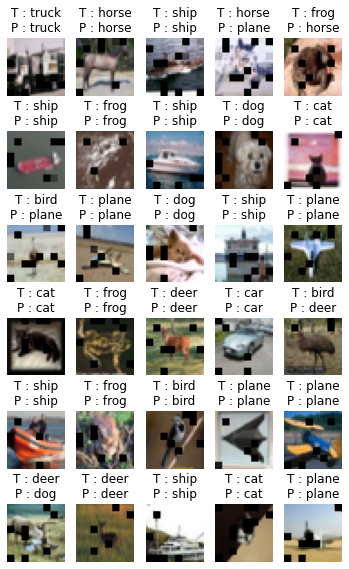

In [68]:
plotting_attention(model, images, labels, classes)

ViT from scratch doesn't look like a model that gives good attention to images. It doesn't even know how much attention it will give and which patch is important for classification. It's all about simply giving or not giving.

# From Pretrained & BIGGGERRRR

## Load Pretrained ViT

In [69]:
!pip install transformers

In [71]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch32-224-in21k')
model_p = ViTModel.from_pretrained('google/vit-large-patch32-224-in21k')


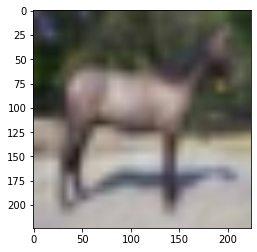

In [78]:
inputs = feature_extractor(images=images[1].to('cpu'), return_tensors="pt")
plotting = inputs.pixel_values.permute(0,2,3,1)[0]
plotting = plotting/2+0.5
plt.imshow(plotting)

## Configure

In [79]:
outputs_p = model_p(output_attentions=True,**inputs)
last_hidden_states = outputs_p.last_hidden_state
print(f"input shape : {list(inputs.pixel_values.shape)}")
print(f"pooler_output shape : {list(outputs_p.pooler_output.shape)}")
print(f"last_hidden_state shape : {list(outputs_p.last_hidden_state.shape)}")
print(f"attentions shape : {list(outputs_p.attentions[-1].shape)}")
print(f"\nimg size : {model_p.config.image_size}")
print(f"patch size : {model_p.config.patch_size}")
print(f"num of patches + CLS : {(model_p.config.image_size//model_p.config.patch_size)**2} + 1")
print(f"num of pixel for each patch : {model_p.config.patch_size**2}")
print(f"patch size : {model_p.config.num_attention_heads}")

input shape : [1, 3, 224, 224]
pooler_output shape : [1, 1024]
last_hidden_state shape : [1, 50, 1024]
attentions shape : [1, 16, 50, 50]

img size : 224
patch size : 32
num of patches + CLS : 49 + 1
num of pixel for each patch : 1024
patch size : 16


In [ ]:
output, att_img = model(images)
att_img = att_img.sum(axis=1)
f = plt.figure(figsize=(6,10))
for i in range(30):
  att = att_img[i][0][1:]
  att = (att - att.min())*10 / (att.max() - att.min())
  att = att.reshape(8,8).to('cpu').detach().numpy().repeat(4).reshape(8,32).repeat(4,axis=0)
  att = np.minimum(att,1)
  ones = np.full_like(att,0)
  att = np.concatenate([ones,ones,ones,att]).reshape(4,32,32).transpose(1,2,0)
  plot_img = images[i].permute(1,2,0).to('cpu').detach().numpy()
  plt.subplot(6,5,i+1)
  plt.title(f"T : {classes[labels[i]]}\nP : {classes[torch.argmax(output,dim=1)[i]]}")
  plt.imshow(plot_img)
  plt.imshow(att)
  plt.axis("off")
plt.show()

(-0.5, 223.5, 223.5, -0.5)

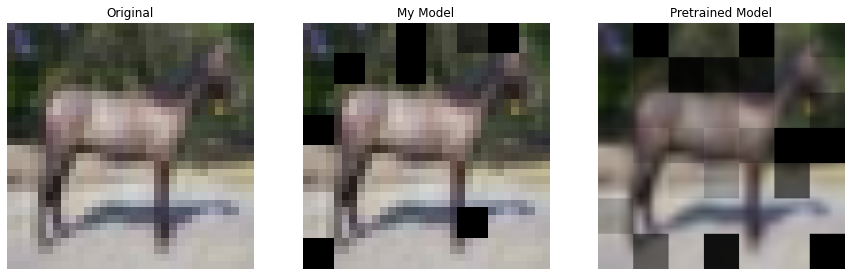

In [90]:
import numpy as np
plotting_p = inputs.pixel_values.permute(0,2,3,1)[0]
plotting_p = plotting_p/2+0.5
att_p = outputs_p.attentions[-1].sum(1)[0][0][1:]
att_p = (att_p - att_p.min())*5 / (att_p.max() - att_p.min())
att_p = att_p.reshape(7,7).detach().numpy().repeat(32).reshape(7,7*32).repeat(32,axis=0)
att_p = np.minimum(att_p,1)
ones = np.full_like(att_p,0)
att_p = np.concatenate([ones,ones,ones,att_p]).reshape(4,224,224).transpose(1,2,0)

output, att_img = model(images[1:2])
att_img = att_img.sum(axis=1)
att = att_img[0][0][1:]
att = (att - att.min())*10 / (att.max() - att.min())
att = att.reshape(8,8).to('cpu').detach().numpy().repeat(4).reshape(8,32).repeat(4,axis=0)
att = np.minimum(att,1)
ones = np.full_like(att,0)
att = np.concatenate([ones,ones,ones,att]).reshape(4,32,32).transpose(1,2,0)
plot_img = images[1].permute(1,2,0).to('cpu').detach().numpy()



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(images[1].permute(1,2,0).to('cpu'))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("My Model")
plt.imshow(plot_img)
plt.imshow(att)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Pretrained Model")
plt.imshow(plotting_p)
plt.imshow(att_p)
plt.axis("off")